In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
from PIL import Image, ImageEnhance
import mahotas as mt
import skimage
from skimage.morphology import disk

In [56]:
from morph_texture import normalize

In [2]:
R, G, B = 0, 1, 2
H, W, CH = 0, 1, 2

In [3]:
def show(img, plt_size=(16, 10), cmap=None):
    fig = plt.figure(figsize=plt_size)
    plt.imshow(img, cmap=cmap if cmap is not None else (None if len(img.shape) == 3 else 'gray'))

In [13]:
downsize_factor = 8

In [177]:
img = imageio.imread('./test_img.png')
img = cv2.resize(img, (img.shape[W] // downsize_factor, img.shape[H] // downsize_factor))
gray = cv2.cvtColor(reg, cv2.COLOR_RGB2GRAY)

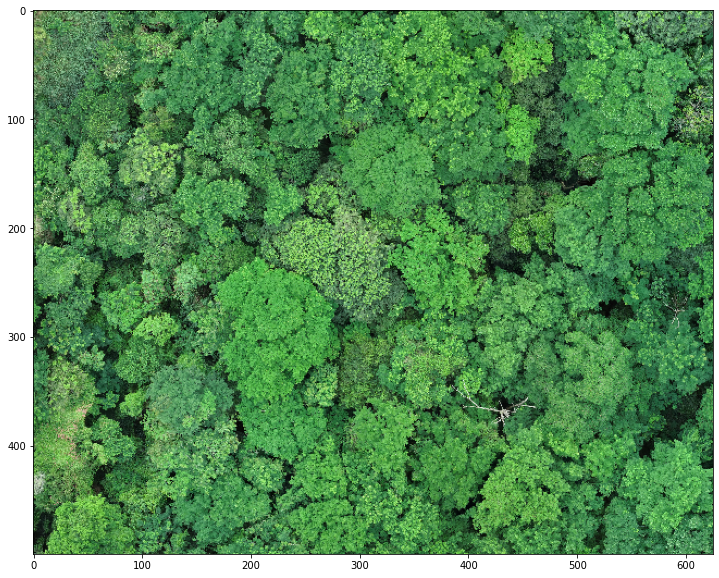

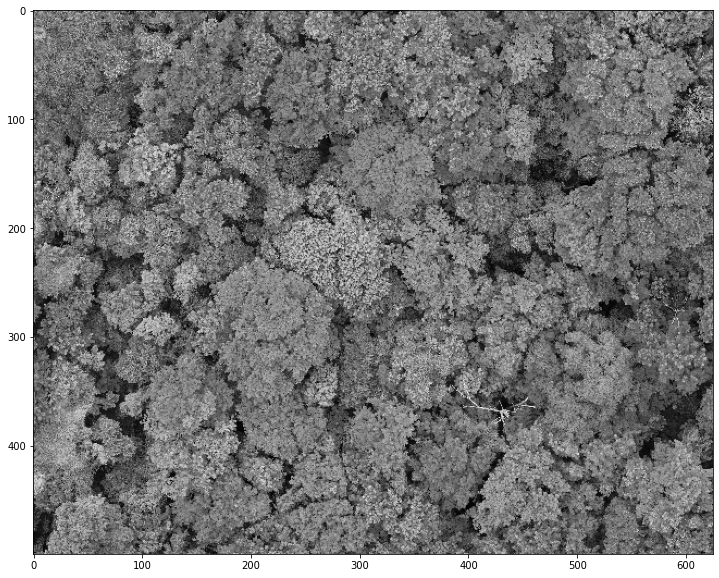

In [178]:
show(img)
show(gray)

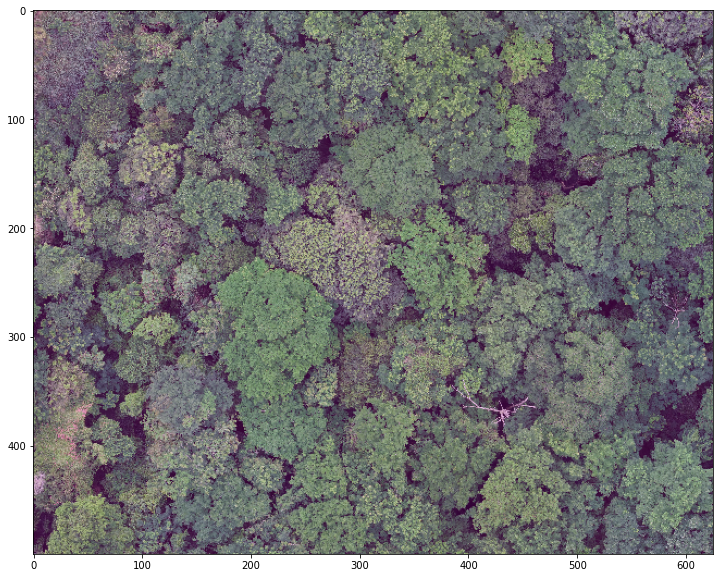

In [176]:
mean_px = np.mean(img, axis=(0,1))
reg = normalize(img - mean_px, (0, 255), np.uint8)

In [179]:
enh = ImageEnhance.Contrast(Image.fromarray(reg))

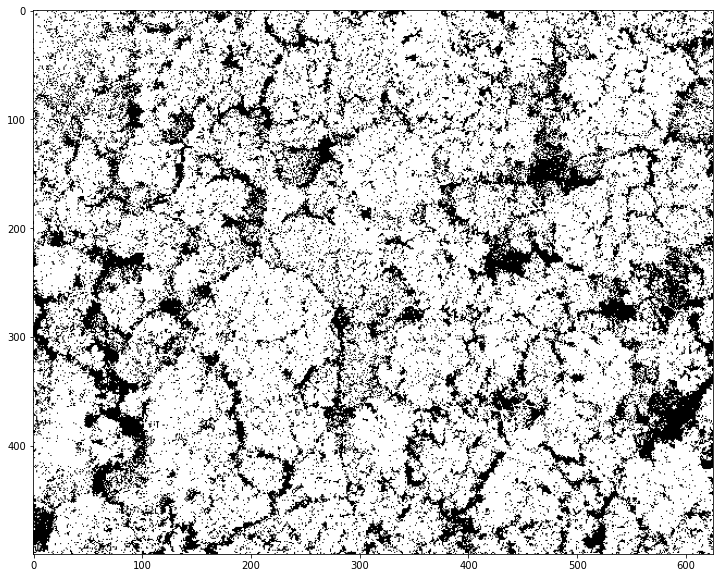

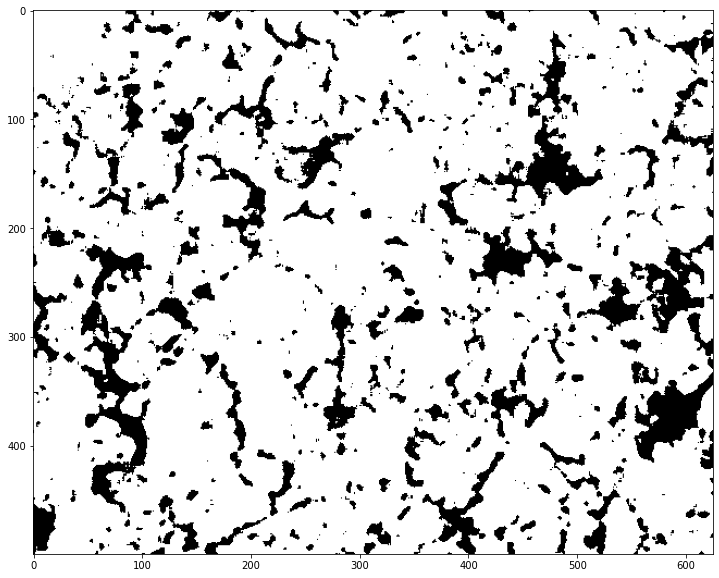

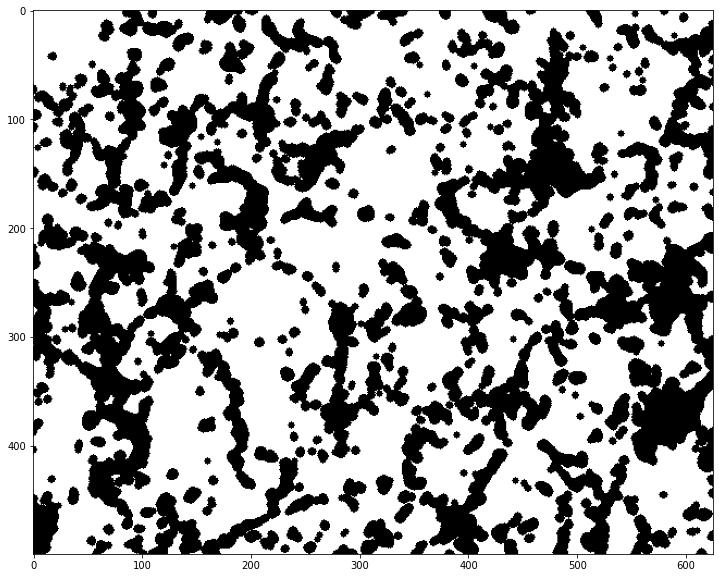

In [191]:
highcontrast = enh.enhance(2.5)
hc = np.asarray(highcontrast)
factor = 0.5
gray_img = cv2.cvtColor(hc, cv2.COLOR_RGB2GRAY)
thresh, bin_img = cv2.threshold(gray_img, 80, 1, cv2.THRESH_OTSU)
_, bin_img = cv2.threshold(gray_img, int(thresh * factor), 1, cv2.THRESH_BINARY)
show(bin_img)
bin_blur = cv2.medianBlur(bin_img, 5)
show(bin_blur)
morph = cv2.morphologyEx(bin_blur, cv2.MORPH_ERODE, disk(3), iterations=1)
show(morph)


In [5]:
def open_img(img, disk_size):
    se = disk(disk_size)
    return cv2.morphologyEx(img, cv2.MORPH_OPEN, se)

In [22]:
def get_crown_size_layers(img, min_disk=3, max_disk=65):
    opened = {'images': {}, 'mean_diffs': {}}
    images = opened['images']
    for disk_size in range(min_disk, max_disk, 2):
        images[disk_size] = cv2.morphologyEx(img, cv2.MORPH_OPEN, disk(disk_size))
    
    mean_diffs = opened['mean_diffs']
    for i, disk_size in enumerate(images.keys()):
        if disk_size == min_disk:
            continue
        mean_diffs[disk_size] = np.mean(images[disk_size] - images[list(images.keys())[i - 1]])
    return opened


In [23]:
csl = get_crown_size_layers(gray)

In [28]:
imgs = csl['images']

In [33]:
np.mean(imgs[5] - imgs[3])

199.2368704

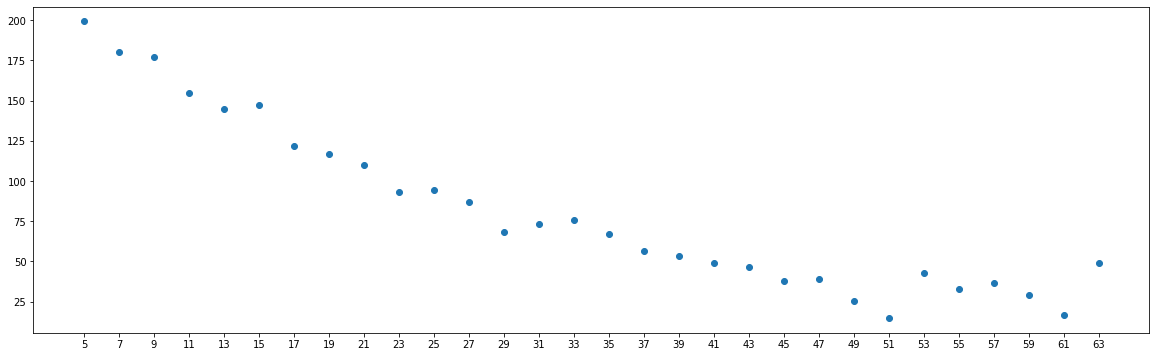

In [41]:
xs = []
ys = []
for sz in csl['mean_diffs']:
    xs.append(sz)
    ys.append(csl['mean_diffs'][sz])

plt.rcParams["figure.figsize"] = (20,6)
plt.plot(xs, ys, 'o')
plt.xticks(np.arange(min(xs), max(xs) + 1, 2))
plt.show()

In [42]:
crown_sizes = [7, 11, 13, 23, 29, 45, 51, 55, 61]

In [57]:
def get_filtered(img, crown_sizes):
    filtered = {}
    for sz in crown_sizes:
        k = sz if sz % 2 == 1 else sz + 1
        filtered[sz] = normalize(cv2.GaussianBlur(img, (k, k), 0.3 * k), (0, 255), np.uint8)
    
    return filtered

In [58]:
filtered = get_filtered(gray, crown_sizes)

In [205]:
def segment_layers(orig_img, filtered, thresh_factor, mask):
    result = {}
    for sz in filtered:
        img = 255 - filtered[sz]
        _, bin_img = cv2.threshold(img,
                                   thresh_factor * np.max(img),
                                   255,
                                   cv2.THRESH_BINARY_INV)
        components = cv2.connectedComponentsWithStats(bin_img)[1]
        result[sz] = cv2.watershed(orig_img, components)
        result[sz] += 1
        result[sz][mask == 0] = 0
    return result

In [208]:
watershed = segment_layers(img, filtered, 0.25, clean)

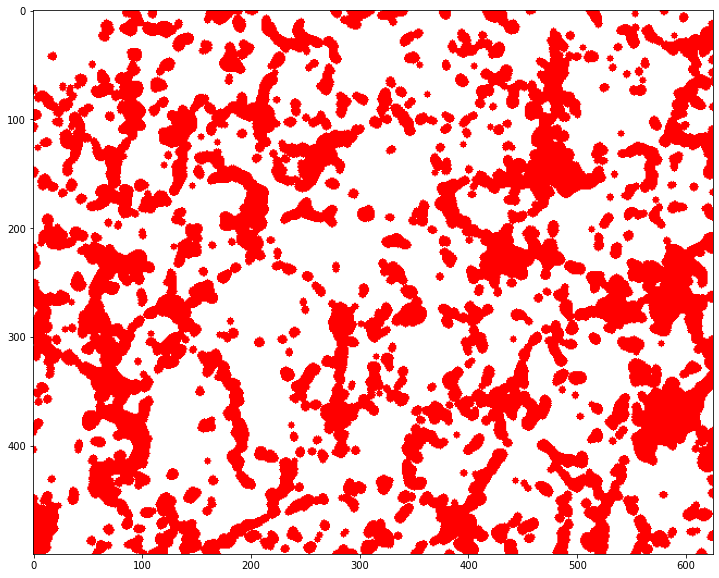

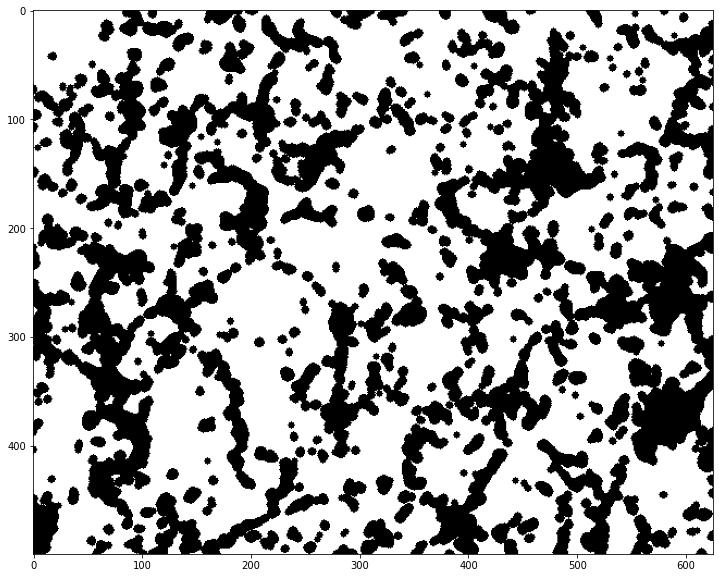

In [200]:
f = normalize(cv2.cvtColor(morph, cv2.COLOR_GRAY2RGB), (0, 255), np.uint8)
f[morph == 0] = (255, 0, 0)
show(f)
show(morph)

In [165]:
watershed.keys()

dict_keys([7, 11, 13, 23, 29, 45, 51, 55, 61])

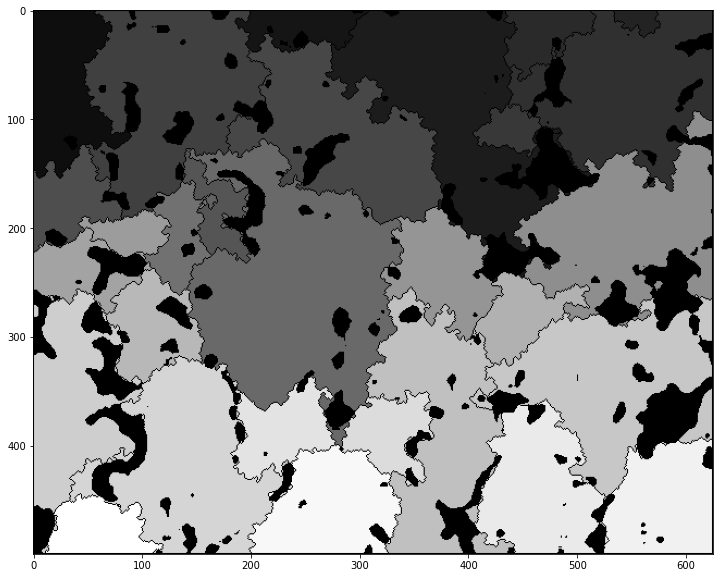

In [210]:
show(watershed[51])

In [133]:
x = normalize(x, (0, 255), np.uint8)

In [159]:
cc = cv2.connectedComponentsWithStats(bin_x)

In [126]:
centroids = cc[3]

In [149]:
cc[1].shape

(500, 625)

In [136]:
x.dtype

dtype('uint8')

In [140]:
canvas = cv2.cvtColor(x, cv2.COLOR_GRAY2RGB)
for h, w in centroids:
    cv2.circle(canvas, (int(h), int(w)), 6, (255, 0, 0), -1)

In [146]:
img.shape

(500, 625, 3)

In [150]:
ws = cv2.watershed(img, cc[1])

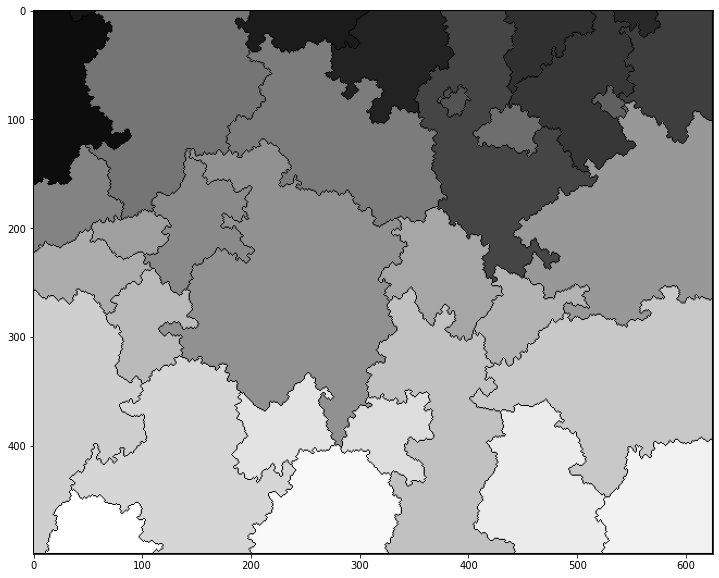

In [153]:
show(ws)